[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tanikina/mi-tutorials/blob/main/notebooks/BERT_QA_Interpretability.ipynb)

### Interpreting BERT Models (Part 1)

This notebook is based on the official Captum tutorial that can be found [here](https://captum.ai/tutorials/Bert_SQUAD_Interpret). Here we focus on a fine-tuned Question Answering model based on SQUAD dataset.

We show how to use interpretation hooks to examine and better understand embeddings, sub-embeddings, BERT, and attention layers. 

In [ ]:
!pip install transformers[torch]
!pip install seaborn
!pip install pandas
!pip install matplotlib
!pip install captum

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients

2025-02-17 09:19:24.640747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739783964.663585    3148 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739783964.670503    3148 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We use a pre-trained tiny BERT model from Hugingface: _mrm8488/bert-tiny-5-finetuned-squadv2_

<img src="images/bert_configs.png" alt="BERT Configurations" width="400"/>

Image source can be found [here](https://www.researchgate.net/figure/arious-configurations-of-the-BERT-architecture-available-for-use-for-reduced_fig1_365004041)

In [3]:
model_path = 'mrm8488/bert-tiny-5-finetuned-squadv2' #'deepset/bert-base-cased-squad2'

# load model
model = BertForQuestionAnswering.from_pretrained(model_path)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)

Some weights of the model checkpoint at mrm8488/bert-tiny-5-finetuned-squadv2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


A helper function to perform forward pass of the model and make predictions.

In [4]:
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask, )
    return output.start_logits, output.end_logits

Defining a custom forward function that will allow us to access the start and end postitions of our prediction using `position` input argument.

In [5]:
def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values


Let's compute attributions with respect to the `BertEmbeddings` layer.

To do so, we need to define baselines / references. The cell below defines special tokens that will be later used for constructing inputs and corresponding baselines/references.

In [6]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

Below we define a set of helper function for constructing references / baselines for word tokens, token types and position ids. We also provide separate helper functions that allow to construct attention masks and bert embeddings both for input and reference.

In [7]:
def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
        [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)
    
    return input_embeddings, ref_input_embeddings


Let's define the `question - text` pair that we'd like to use as an input for our Bert model and interpret what the model was focusing on when predicting an answer to the question from the given input text.

In [8]:
question, text = "What is important to us?", "It is important to us to empower and support humans of all kinds."

Let's generate corresponding baselines / references for all three sub-embeddings (word, token type and position embeddings) types using our helper functions defined above.

In [9]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

Also, let's define the ground truth for prediction's start and end positions.

In [10]:
ground_truth = 'to empower and support humans of all kinds'

ground_truth_tokens = tokenizer.encode(ground_truth, add_special_tokens=False)
ground_truth_end_ind = indices.index(ground_truth_tokens[-1])
ground_truth_start_ind = ground_truth_end_ind - len(ground_truth_tokens) + 1

Now let's make predictions using input, token type, position id and a default attention mask.

In [11]:
start_scores, end_scores = predict(input_ids, \
                                   token_type_ids=token_type_ids, \
                                   position_ids=position_ids, \
                                   attention_mask=attention_mask)


print('Question: ', question)
print('Predicted Answer: ', ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))

Question:  What is important to us?
Predicted Answer:  em ##power and support humans of all kinds


There are two different ways of computing the attributions for embedding layers. One option is to use `LayerIntegratedGradients` and compute the attributions with respect to `BertEmbedding`. The second option is to use `LayerIntegratedGradients` for each `word_embeddings`, `token_type_embeddings` and `position_embeddings` and compute the attributions w.r.t each embedding vector.


In [12]:
lig = LayerIntegratedGradients(squad_pos_forward_func, model.bert.embeddings)

attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                  baselines=ref_input_ids,
                                  additional_forward_args=(token_type_ids, position_ids, attention_mask, 0),
                                  return_convergence_delta=True)
attributions_end, delta_end = lig.attribute(inputs=input_ids, baselines=ref_input_ids,
                                additional_forward_args=(token_type_ids, position_ids, attention_mask, 1),
                                return_convergence_delta=True)

A helper function to summarize attributions for each word token in the sequence.

In [13]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [14]:
attributions_start_sum = summarize_attributions(attributions_start)
attributions_end_sum = summarize_attributions(attributions_end)

In [15]:
# storing couple samples in an array for visualization purposes
start_position_vis = viz.VisualizationDataRecord(
                        attributions_start_sum,
                        torch.max(torch.softmax(start_scores[0], dim=0)),
                        torch.argmax(start_scores),
                        torch.argmax(start_scores),
                        str(ground_truth_start_ind),
                        attributions_start_sum.sum(),       
                        all_tokens,
                        delta_start)

end_position_vis = viz.VisualizationDataRecord(
                        attributions_end_sum,
                        torch.max(torch.softmax(end_scores[0], dim=0)),
                        torch.argmax(end_scores),
                        torch.argmax(end_scores),
                        str(ground_truth_end_ind),
                        attributions_end_sum.sum(),       
                        all_tokens,
                        delta_end)

print('\033[1m', 'Visualizations For Start Position', '\033[0m')
viz.visualize_text([start_position_vis])

print('\033[1m', 'Visualizations For End Position', '\033[0m')
viz.visualize_text([end_position_vis])

 Visualizations For Start Position 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
14,14 (0.61),13,2.07,[CLS] what is important to us ? [SEP] it is important to us to em ##power and support humans of all kinds . [SEP]


 Visualizations For End Position 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
21,21 (0.36),21,1.60,[CLS] what is important to us ? [SEP] it is important to us to em ##power and support humans of all kinds . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
21,21 (0.36),21,1.60,[CLS] what is important to us ? [SEP] it is important to us to em ##power and support humans of all kinds . [SEP]


From the results above we can tell that for predicting start and end position our model is focusing on the question side but also "empower" is important for predicting the start position and "of all kinds" becomes slightly more important for predicting the end position.

#### Multi-Embedding attribution

Now let's look into the sub-embeddings of `BerEmbeddings` and try to understand the contributions and roles of each of them for both start and end predicted positions.

To do so, we will use `LayerIntegratedGradients` for all three layer:  `word_embeddings`, `token_type_embeddings` and `position_embeddings`.

Quick reminder for Integrated Gradients:

<img src="images/integrated_gradients_formula1.png" alt="Integrated Gradients" width="700"/>

Source: [https://distill.pub/2020/attribution-baselines/](https://distill.pub/2020/attribution-baselines/)

Now let's create an instance of `LayerIntegratedGradients` and compute the attributions with respect to all those embeddings both for the start and end positions and summarize them for each word token.

In [16]:
lig2 = LayerIntegratedGradients(squad_pos_forward_func, \
                                [model.bert.embeddings.word_embeddings, \
                                 model.bert.embeddings.token_type_embeddings, \
                                 model.bert.embeddings.position_embeddings])

attributions_start = lig2.attribute(inputs=(input_ids, token_type_ids, position_ids),
                                  baselines=(ref_input_ids, ref_token_type_ids, ref_position_ids),
                                  additional_forward_args=(attention_mask, 0))
attributions_end = lig2.attribute(inputs=(input_ids, token_type_ids, position_ids),
                                  baselines=(ref_input_ids, ref_token_type_ids, ref_position_ids),
                                  additional_forward_args=(attention_mask, 1))

attributions_start_word = summarize_attributions(attributions_start[0])
attributions_end_word = summarize_attributions(attributions_end[0])

attributions_start_token_type = summarize_attributions(attributions_start[1])
attributions_end_token_type = summarize_attributions(attributions_end[1])

attributions_start_position = summarize_attributions(attributions_start[2])
attributions_end_position = summarize_attributions(attributions_end[2])


/root/miniconda3/envs/nlp-env/lib/python3.11/site-packages/captum/attr/_core/layer/layer_integrated_gradients.py:101: UserWarning: Multiple layers provided. Please ensure that each layer is**not** solely dependent on the outputs ofanother layer. Please refer to the documentation for moredetail.
  warnings.warn(


An auxilary function that will help us to compute topk attributions and corresponding indices

In [17]:
def get_topk_attributed_tokens(attrs, k=5):
    values, indices = torch.topk(attrs, k)
    top_tokens = [all_tokens[idx] for idx in indices]
    return top_tokens, values, indices

Computing topk attributions for all sub-embeddings and placing them in pandas dataframes for better visualization.

In [18]:
top_words_start, top_words_val_start, top_word_ind_start = get_topk_attributed_tokens(attributions_start_word)
top_words_end, top_words_val_end, top_words_ind_end = get_topk_attributed_tokens(attributions_end_word)

top_token_type_start, top_token_type_val_start, top_token_type_ind_start = get_topk_attributed_tokens(attributions_start_token_type)
top_token_type_end, top_token_type_val_end, top_token_type_ind_end = get_topk_attributed_tokens(attributions_end_token_type)

top_pos_start, top_pos_val_start, pos_ind_start = get_topk_attributed_tokens(attributions_start_position)
top_pos_end, top_pos_val_end, pos_ind_end = get_topk_attributed_tokens(attributions_end_position)

df_start = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words_start, top_word_ind_start, top_words_val_start)],
                   'Token Type(Index), Attribution': ["{} ({}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type_start, top_token_type_ind_start, top_words_val_start)],
                   'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos_start, pos_ind_start, top_pos_val_start)]})
df_start.style.apply(['cell_ids: False'])

df_end = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words_end, top_words_ind_end, top_words_val_end)],
                   'Token Type(Index), Attribution': ["{} ({}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type_end, top_token_type_ind_end, top_words_val_end)],
                   'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos_end, pos_ind_end, top_pos_val_end)]})
df_end.style.apply(['cell_ids: False'])

['{}({})'.format(token, str(i)) for i, token in enumerate(all_tokens)]

['[CLS](0)',
 'what(1)',
 'is(2)',
 'important(3)',
 'to(4)',
 'us(5)',
 '?(6)',
 '[SEP](7)',
 'it(8)',
 'is(9)',
 'important(10)',
 'to(11)',
 'us(12)',
 'to(13)',
 'em(14)',
 '##power(15)',
 'and(16)',
 'support(17)',
 'humans(18)',
 'of(19)',
 'all(20)',
 'kinds(21)',
 '.(22)',
 '[SEP](23)']

Below we can see top 5 attribution results from all three embedding types in predicting start positions.

#### Top 5 attributed embeddings for start position

In [19]:
df_start

,"Word(Index), Attribution","Token Type(Index), Attribution","Position(Index), Attribution"
0,"all (20), 0.26","humans (18), 0.26","important (3), 0.52"
1,"? (6), 0.26","us (12), 0.26","[SEP] (7), 0.41"
2,"em (14), 0.24","is (9), 0.24","[SEP] (23), 0.33"
3,"important (3), 0.21","kinds (21), 0.21","##power (15), 0.31"
4,"it (8), 0.16","em (14), 0.16","to (13), 0.2"


Word embeddings help to focus more on the surrounding tokens of the predicted answer's start position e.g. "em" and it also has high attribution for the tokens in the question such as "important" and "?".

Token embedding type focuses more on the tokens towards the end of the input: "humans" and "kinds".

Position embedding has high attribution score for the \[SEP\] tokens but also the tokens close to the output span: "##power" and "to".

We can perform similar analysis, and visualize top 5 attributed tokens for all three embedding types, also for the end position prediction.

#### Top 5 attributed embeddings for end position

In [20]:
df_end

,"Word(Index), Attribution","Token Type(Index), Attribution","Position(Index), Attribution"
0,"##power (15), 0.25","us (12), 0.25","important (3), 0.53"
1,"em (14), 0.23","humans (18), 0.23","[SEP] (7), 0.42"
2,"all (20), 0.08","kinds (21), 0.08","[SEP] (23), 0.27"
3,"support (17), 0.07","em (14), 0.07","? (6), 0.25"
4,"? (6), 0.07","##power (15), 0.07","support (17), 0.24"


`em` and `##power` have the highest word attributions and also appear among the most attributed token types.

The token `kinds`, which is the correct predicted token, appears to have high attribution score according to the token type embeddings.

### Interpreting Bert Layers

Now let's look into the layers of our network. More specifically we would like to look into the distribution of attribution scores for each token across all layers in Bert model and dive deeper into specific tokens. We can do that using one of layer attribution algorithms, namely, `LayerConductance`.

What is `LayerConductance`?

First, let's start again with the Integrated Gradients formula...

<img src="images/integrated_gradients_formula2.png" alt="Layer Conductance" width="400"/>

x and x<sub>i</sub> correspond to the input and the baseline. F is a function representing the neural network.

Note that Integrated Gradients produce attributions for base features (e.g. the pixels of an object recognition network). There is a natural way to ‘lift’ these attributions to a neuron in a hidden layer. Consider a specific neuron y in a hidden layer of a network. We can define the conductance of neuron y for the attribution to an input variable i and then just sum over the input variables.

<img src="images/layer_conductance.png" alt="Layer Conductance" width="500"/>

See [(Dhamdhere et al., 2018)](https://arxiv.org/pdf/1805.12233) for more detail.

Now let's define another version of SQUAD forward function that takes embeddings as input argument. This is necessary for `LayerConductance` algorithm.

In [21]:
def squad_pos_forward_func2(input_emb, attention_mask=None, position=0):
    pred = model(inputs_embeds=input_emb, attention_mask=attention_mask, )
    pred = pred[position]
    return pred.max(1).values

Let's iterate over all layers and compute the attributions for all tokens. In addition to that let's also choose a specific token that we would like to examine in detail, specified by an id `token_to_explain` and store related information in a separate array.

In [22]:
layer_attrs_start = []
layer_attrs_end = []

# The token that we would like to examine separately.
token_to_explain = 21 # the index of the token that we would like to examine more thoroughly
layer_attrs_start_dist = []
layer_attrs_end_dist = []

input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)


In [23]:
for i in range(model.config.num_hidden_layers):
    lc = LayerConductance(squad_pos_forward_func2, model.bert.encoder.layer[i])
    layer_attributions_start = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(attention_mask, 0))
    layer_attributions_end = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(attention_mask, 1))
    layer_attrs_start.append(summarize_attributions(layer_attributions_start).cpu().detach().tolist())
    layer_attrs_end.append(summarize_attributions(layer_attributions_end).cpu().detach().tolist())

    # storing attributions of the token id that we would like to examine in more detail in token_to_explain
    layer_attrs_start_dist.append(layer_attributions_start[0,token_to_explain,:].cpu().detach().tolist())
    layer_attrs_end_dist.append(layer_attributions_end[0,token_to_explain,:].cpu().detach().tolist())

The plot below represents a heat map of attributions across all layers and tokens for the start position prediction. 
It is interesting to observe that the word `important` has high attribution in the first 3 layers and then it becomes less important. The token `humans` has low scores in the first two layers but then gets increasingly higher attributions. The predicted token `em` is also assigned high attribution score which is remarkably high the last three layers.

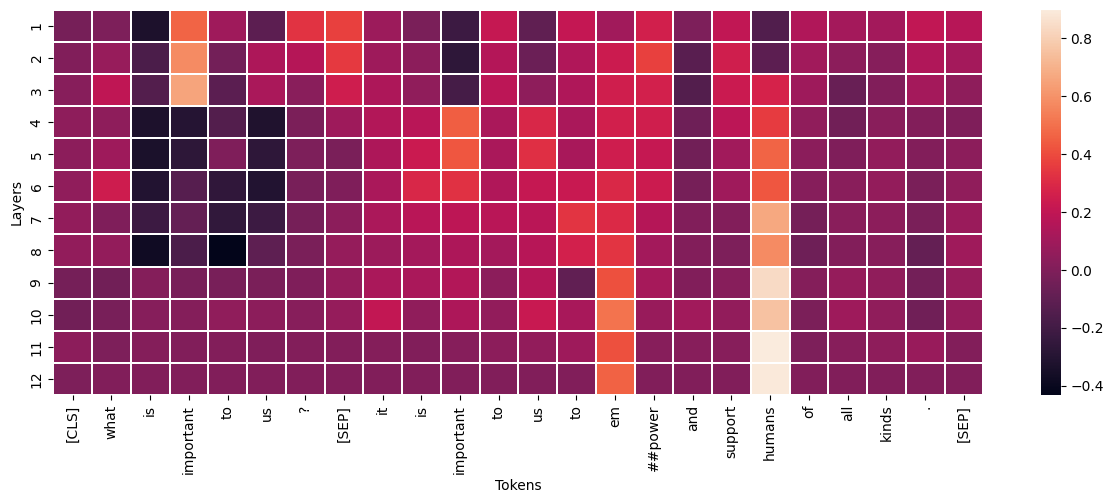

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs_start), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

Now let's examine the heat map of the attributions for the end position prediction. The correctly predicted end token `kinds` has positive attribution in the last layer and `humans` has high attributions across all layers.

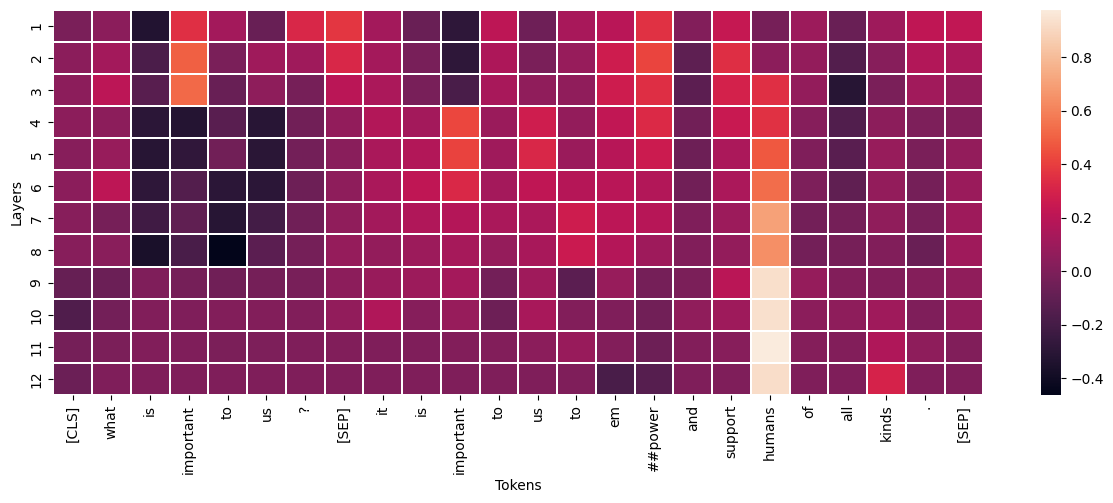

In [25]:
fig, ax = plt.subplots(figsize=(15,5))

xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs_end), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2) #, annot=True
plt.xlabel('Tokens')
plt.ylabel('Layers')

plt.show()

Now let's dig deeper into specific tokens and look into the distribution of attributions per layer for the token `kinds` in the start and end positions. The box plot diagram below shows the presence of outliers especially in the first two layers, layer 4 and 5. We also observe that for start position prediction interquartile range slowly decreases as we go deeper into the layers and finally it is dimishing.

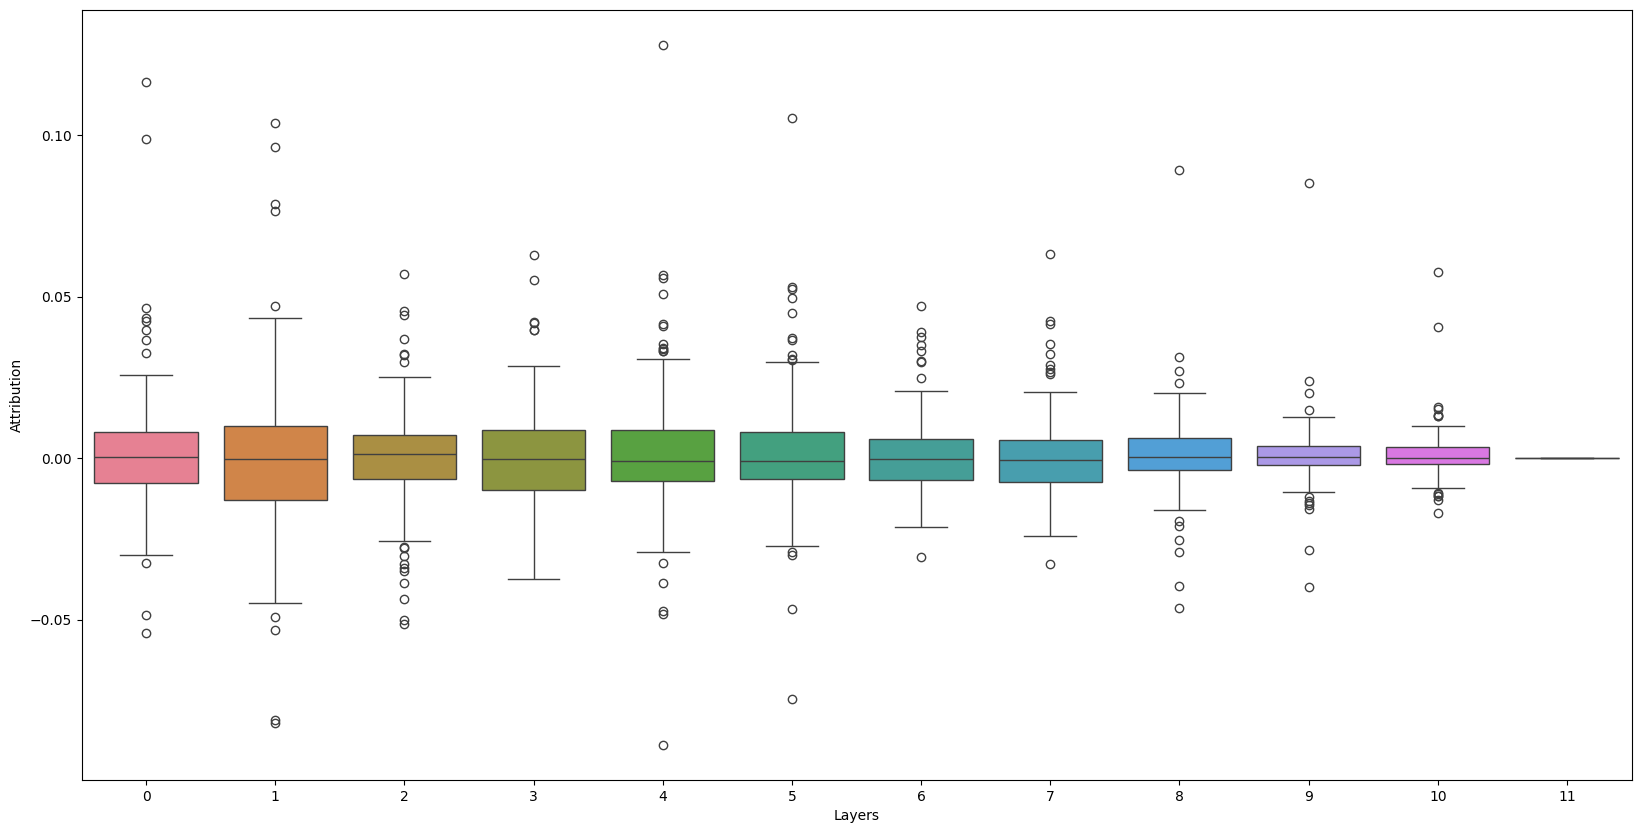

In [26]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_start_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

Now let's plot same distribution but for the prediction of the end position. Here the interquartile range doesn't change much when moving deeper into the layers.

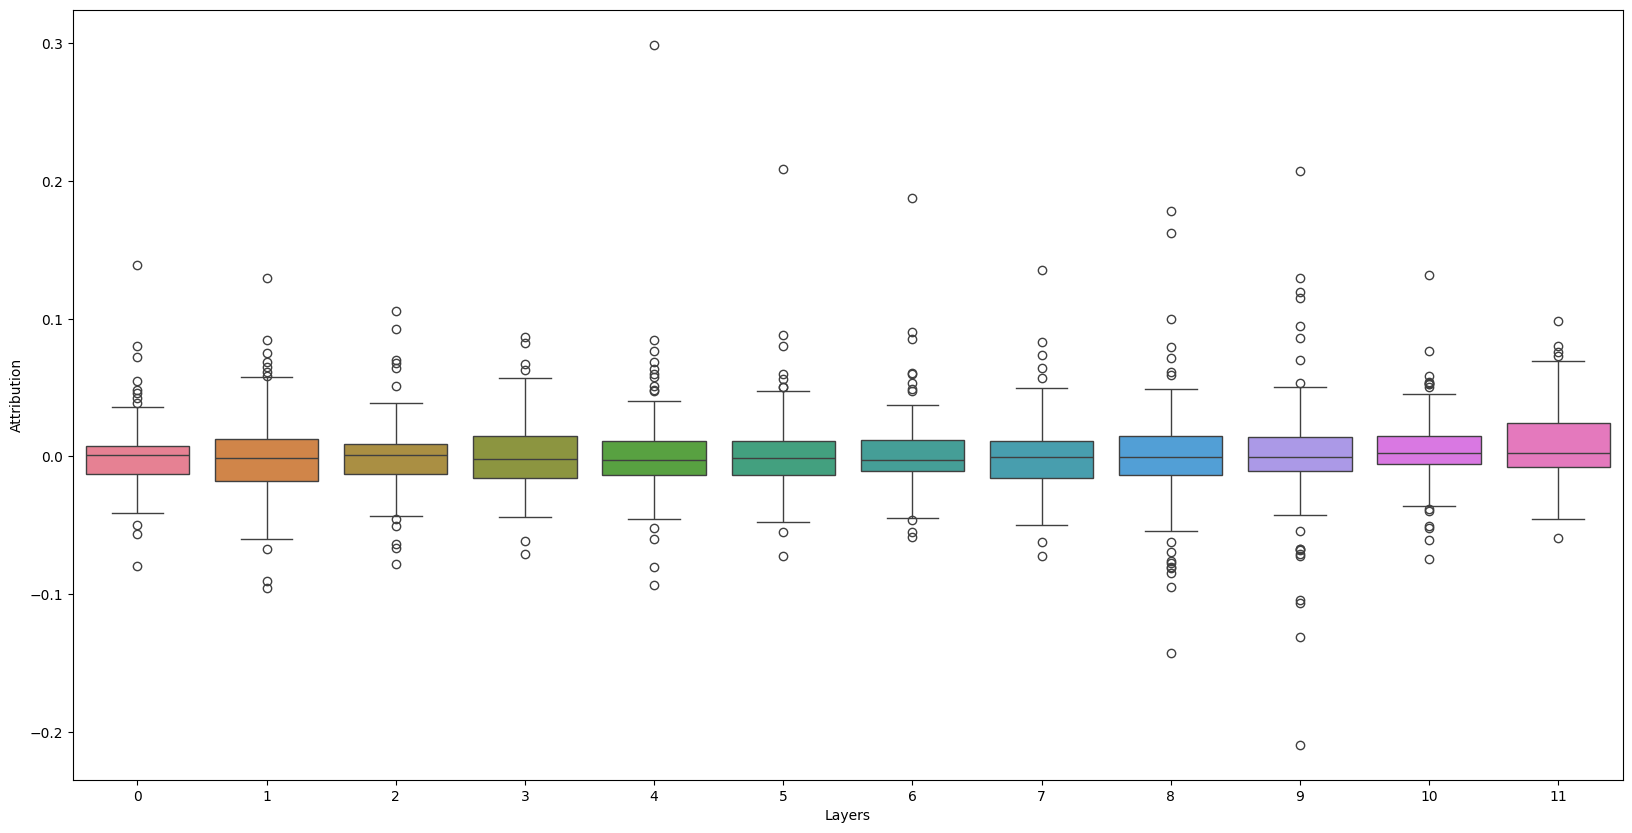

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_end_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

In addition to that we can also look into the distribution of attributions in each layer for any input token. This will help us to better understand and compare the distributional patterns of attributions across multiple layers. We can e.g. represent attributions as a probability density function (pdf) and compute the entropy of it in order to estimate the entropy of attributions in each layer. This can be easily computed using a histogram.

In [28]:
def pdf_attr(attrs, bins=100):
    return np.histogram(attrs, bins=bins, density=True)[0]

In this particular case let's compute the pdf for the attributions at end positions `kinds`. We can however do it for all tokens.

We will compute and visualize the pdfs and entropies using Shannon's Entropy measure for each layer for token `kinds`.

In [29]:
layer_attrs_end_pdf = map(lambda layer_attrs_end_dist: pdf_attr(layer_attrs_end_dist), layer_attrs_end_dist)
layer_attrs_end_pdf = np.array(list(layer_attrs_end_pdf))

# summing attribution along embedding diemension for each layer
# size: #layers
attr_sum = np.array(layer_attrs_end_dist).sum(-1)

# size: #layers
layer_attrs_end_pdf_norm = np.linalg.norm(layer_attrs_end_pdf, axis=-1, ord=1)

#size: #bins x #layers
layer_attrs_end_pdf = np.transpose(layer_attrs_end_pdf)

#size: #bins x #layers
layer_attrs_end_pdf = np.divide(layer_attrs_end_pdf, layer_attrs_end_pdf_norm, where=layer_attrs_end_pdf_norm!=0)

The plot below visualizes the probability mass function (pmf) of attributions for each layer for the end position token `kinds`. From the plot we can observe that the distributions are taking bell-curved shapes with different means and variances.
We can now use attribution pdfs to compute entropies in the next cell.

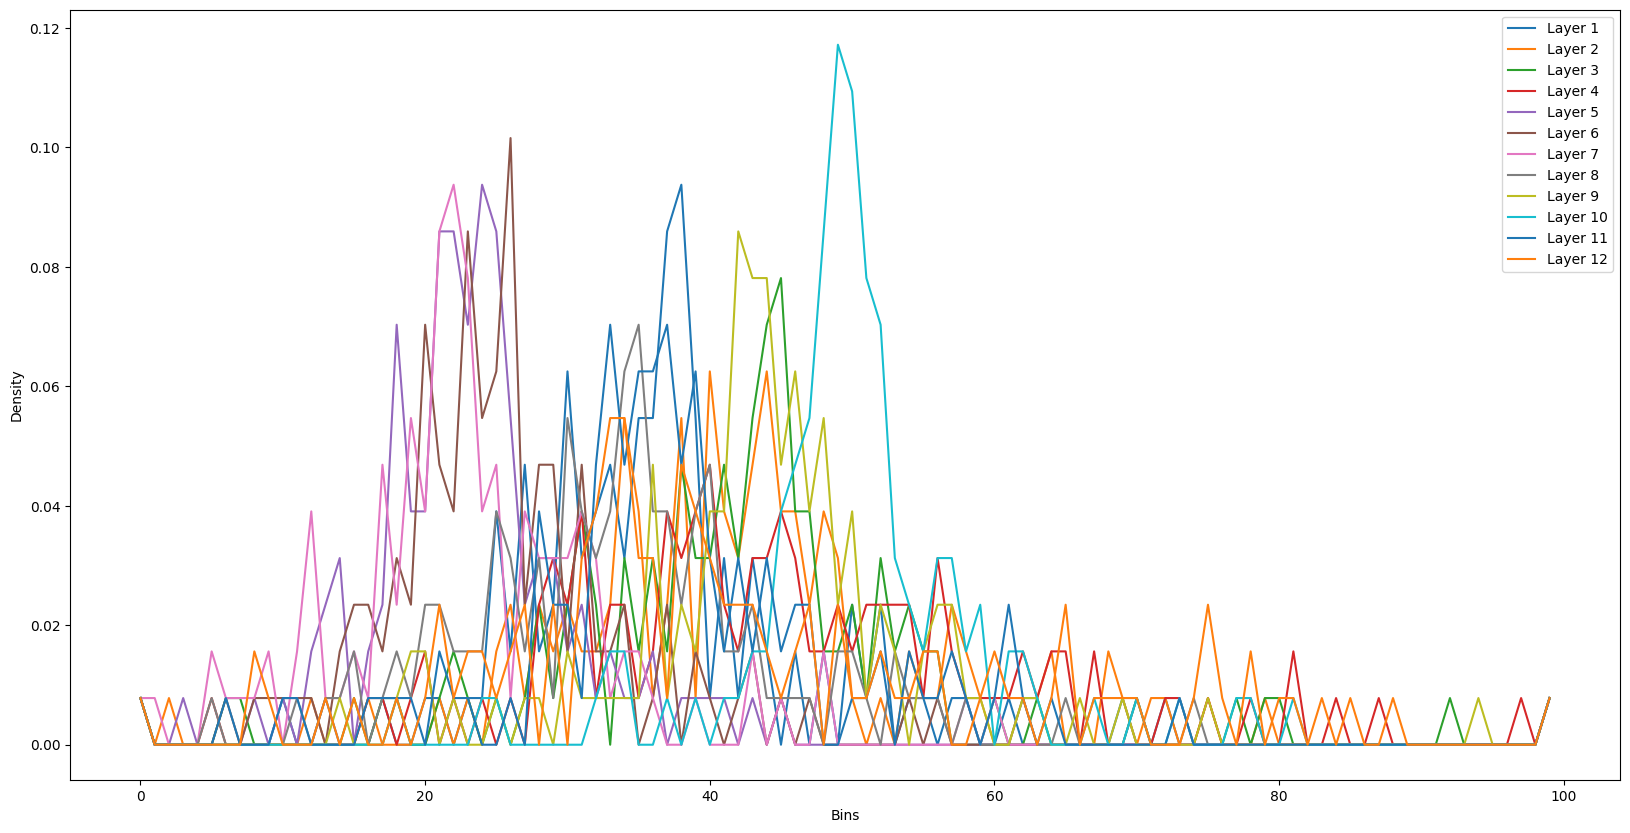

In [30]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(layer_attrs_end_pdf)
plt.xlabel('Bins')
plt.ylabel('Density')
plt.legend(['Layer '+ str(i) for i in range(1,13)])
plt.show()

Below we calculate and visualize attribution entropies based on Shannon entropy measure where the x-axis corresponds to the number of layers and the y-axis corresponds to the total attribution in that layer. The size of the circles for each (layer, total_attribution) pair correspond to the normalized entropy value at that point.

In this particular example, we observe that the entropy does not change much across the layers while the attribution scores increase in the last 3 layers. In general, entropy can provide us an intuition about the distributional characteristics of attributions in each layer and can be useful especially when comparing it across multiple tokens.

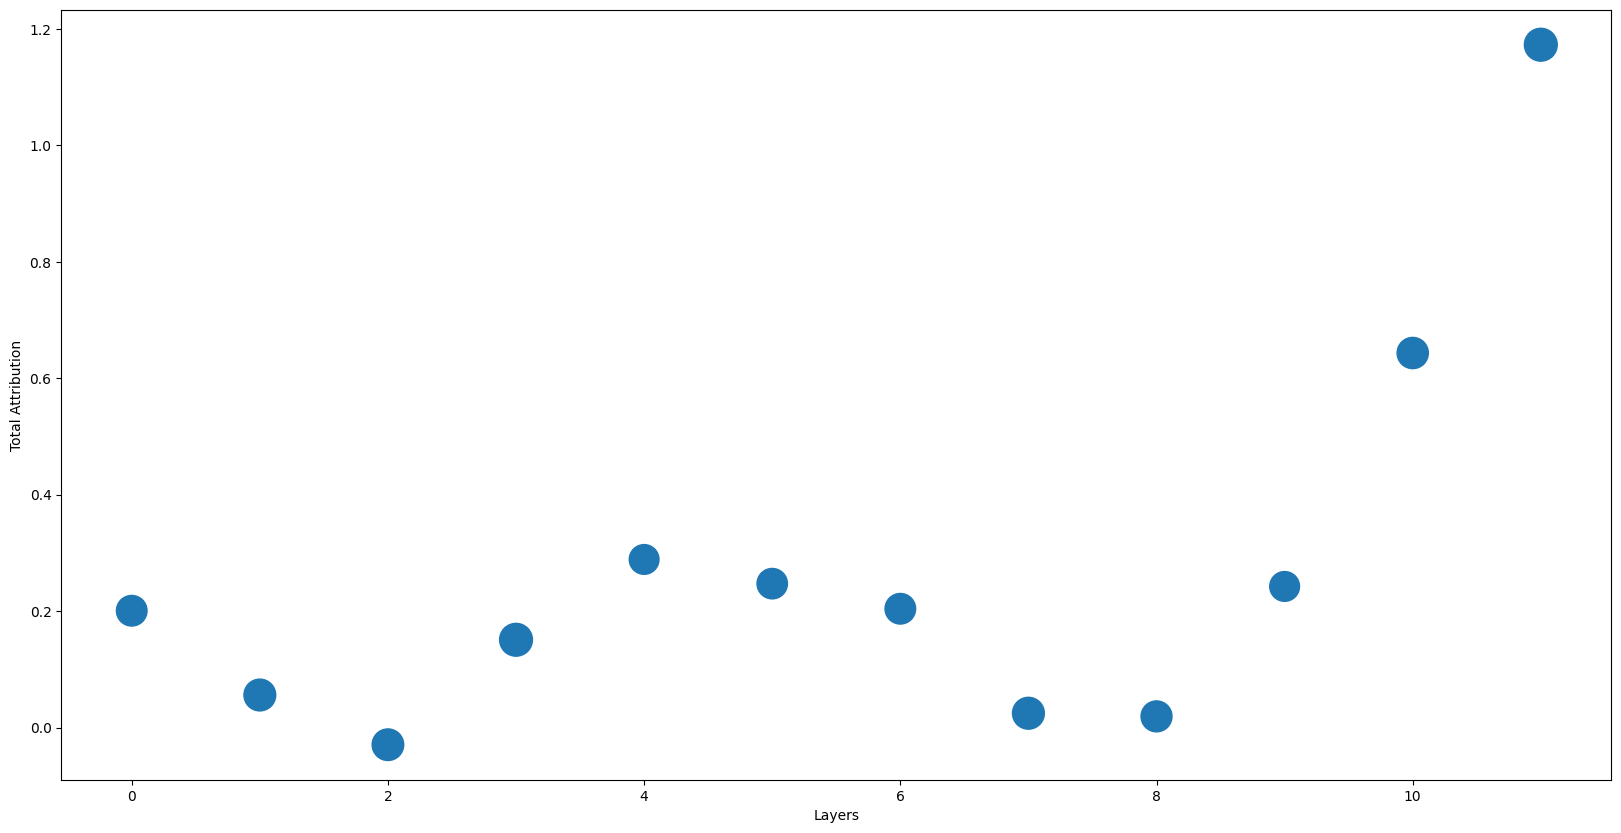

In [31]:
fig, ax = plt.subplots(figsize=(20,10))

# replacing 0s with 1s. np.log(1) = 0 and np.log(0) = -inf
layer_attrs_end_pdf[layer_attrs_end_pdf == 0] = 1
layer_attrs_end_pdf_log = np.log2(layer_attrs_end_pdf)

# size: #layers
entropies= -(layer_attrs_end_pdf * layer_attrs_end_pdf_log).sum(0)

plt.scatter(np.arange(12), attr_sum, s=entropies * 100)
plt.xlabel('Layers')
plt.ylabel('Total Attribution')
plt.show()

In the Part 2 of this tutorial we will to go deeper into attention layers, heads and compare the attributions with the attention weight matrices, study and discuss related statistics.